In [1]:
!pip install seaborn matplotlib

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.4 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 26.7 MB/s eta 0:00:00
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from operator import methodcaller

import polars as pl
import numpy as np
import renkon.api as rk

import seaborn as sns
import matplotlib.pyplot as plt


def plot_linreg(m, c, *, ax):
    """ Plot y = mx + c """
    ax = ax or plt.gca()
    x = np.array(ax.get_xlim())
    y = m * x + c
    ax.plot(x, y, color="green", linestyle=":")

%load_ext autoreload
%autoreload 2

In [3]:
cereals_df = pl.read_csv("../etc/samples/cereals.csv", separator=";", skip_rows_after_header=1).with_columns(
    carbs=pl.col("carbo") + pl.col("sugars"),
)
cereals_df

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,carbs
str,str,str,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
"""100% Bran""","""N""","""C""",70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973,11.0
"""100% Natural B…","""Q""","""C""",120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.0,33.983679,16.0
"""All-Bran""","""K""","""C""",70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505,12.0
"""All-Bran with …","""K""","""C""",50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.5,93.704912,8.0
"""Almond Delight…","""R""","""C""",110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843,22.0
"""Apple Cinnamon…","""G""","""C""",110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,20.5
"""Apple Jacks""","""K""","""C""",110,2,0,125,1.0,11.0,14,30,25,2,1.0,1.0,33.174094,25.0
"""Basic 4""","""G""","""C""",130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562,26.0
"""Bran Chex""","""R""","""C""",90,2,1,200,4.0,15.0,6,125,25,1,1.0,0.67,49.120253,21.0


In [4]:
cereals_df.write_csv("../etc/samples/cereals-cleaned.csv", separator=",")

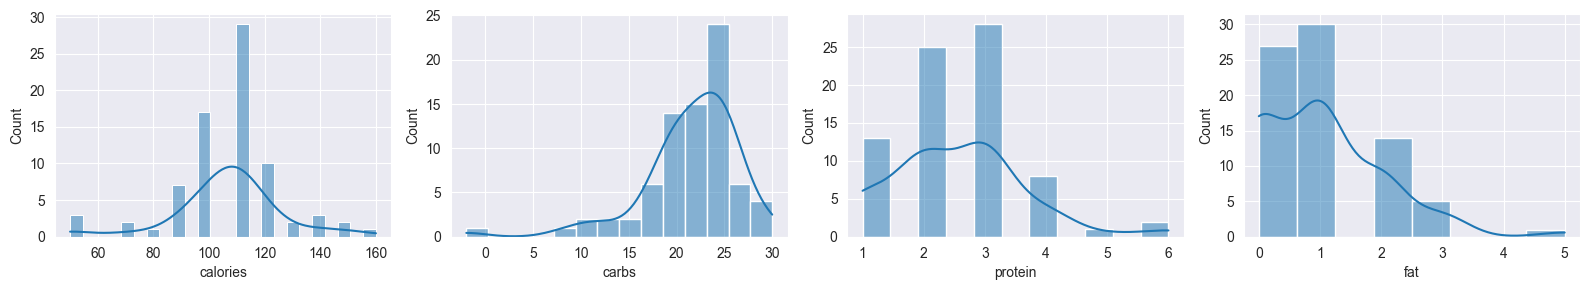

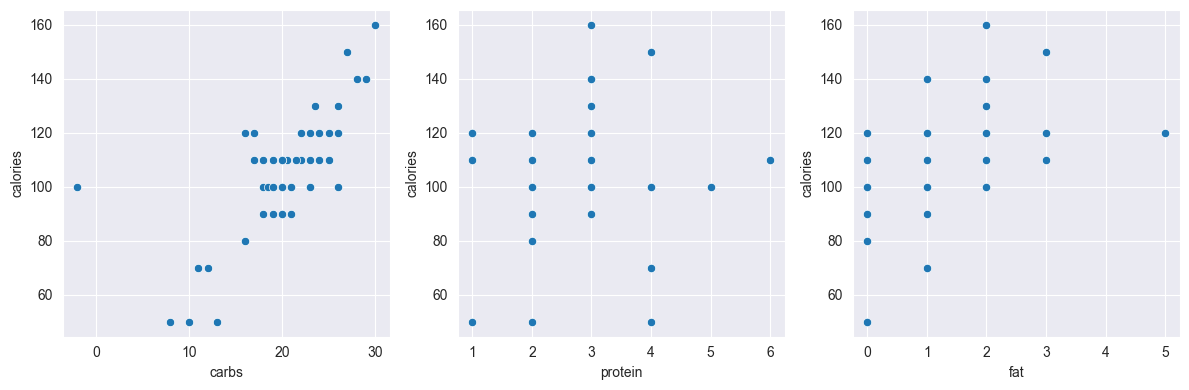

In [3]:
# Data Inspection

fig, axs = plt.subplots(1, 4, figsize=(16, 3))
sns.histplot(ax=axs[0], data=cereals_df, x="calories", kde=True);
sns.histplot(ax=axs[1], data=cereals_df, x="carbs", kde=True);
sns.histplot(ax=axs[2], data=cereals_df, x="protein", kde=True);
sns.histplot(ax=axs[3], data=cereals_df, x="fat", kde=True);
fig.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(ax=axs[0], data=cereals_df, x="carbs", y="calories")
sns.scatterplot(ax=axs[1], data=cereals_df, x="protein", y="calories")
sns.scatterplot(ax=axs[2], data=cereals_df, x="fat", y="calories")
fig.tight_layout()

In [4]:
CALORIES_PER = {
    "carbs": 4,
    "protein": 4,
    "fat": 9,
}

cals_df = cereals_df.select(
    pl.col("name"),
    pl.col("calories").alias("cals_from_label"),
    pl.concat_list("carbs", "protein", "fat").apply(
        methodcaller("dot", CALORIES_PER.values())
    ).alias("cals_from_macros")
)
cals_df

name,cals_from_label,cals_from_macros
str,i64,f64
"""100% Bran""",70,69.0
"""100% Natural B…",120,121.0
"""All-Bran""",70,73.0
"""All-Bran with …",50,48.0
"""Almond Delight…",110,114.0
"""Apple Cinnamon…",110,108.0
"""Apple Jacks""",110,108.0
"""Basic 4""",130,134.0
"""Bran Chex""",90,101.0


In [5]:
model, fit = rk.stats.linear_fit(data=cereals_df, y="calories", x=["carbs", "protein", "fat"])
fit.params

OLSParams(m=array([3.18008835, 4.46475158, 9.13673172]), c=17.82905484599198)

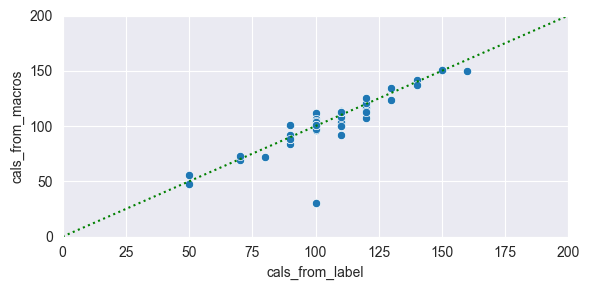

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.plot([0, 200], [0, 200], color="green", linestyle=":")
sns.scatterplot(ax=ax, data=cals_df, x="cals_from_label", y="cals_from_macros")
fig.tight_layout()

# Definitions

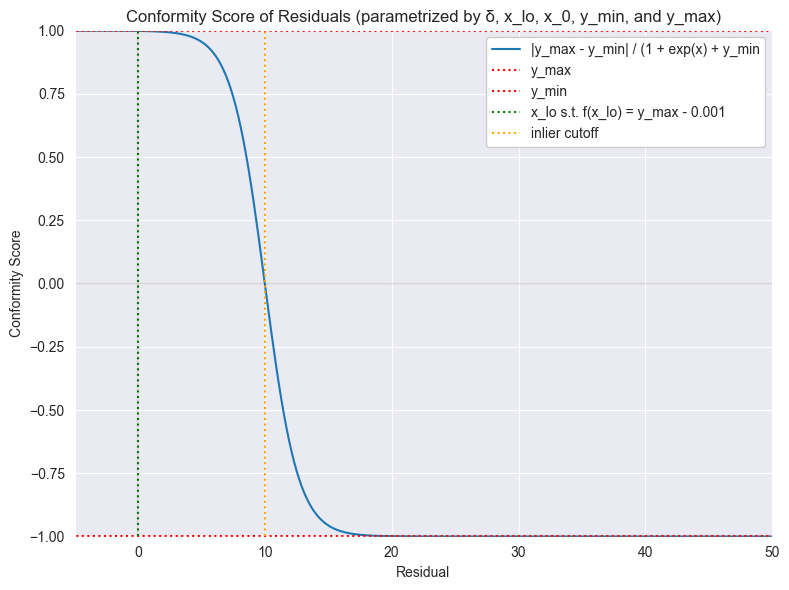

In [201]:
import functools as ft
# Draw a parametrized sigmoid:

dist = lambda a, b: np.abs(a - b)

delta = 0.001

# y-values of sigmoids asymptotes:
y_max = 1
y_min = -1

# "Amplitude" of the sigmoid:
amp = dist(y_max, y_min)

# x-values where the sigmoid is at 0, reaches y_max - delta, and y_min + delta:
x_lo = 0
x_0 = 10

x_hi = 2 * (x_0 - x_lo)

# "Wavelength" of the sigmoid:
wlen = dist(x_hi, x_lo)

k = (np.log(amp/delta - 1) - np.log(amp/(amp - delta) -1)) / wlen

x = np.linspace(-100, 100, 1000)
y = 1 / (1 + np.exp(k*(x - x_0)))
y = dist(y_min, y_max) * y + y_min

# ---

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(y_min - delta, y_max + delta)

ax.plot(x, y, label="|y_max - y_min| / (1 + exp(x) + y_min")

# Draw lines for y_max and y_min:
ax.hlines(y_max, np.min(x), np.max(x), color="red", linestyle=":", label="y_max")
ax.hlines(y_min, np.min(x), np.max(x), color="red", linestyle=":", label="y_min")

# Draw vertical lines for x_lo and x_hi:
ax.vlines(x_lo, np.min(y), np.max(y), color="green", linestyle=":", label=f"x_lo s.t. f(x_lo) = y_max - {delta}")
# ax.vlines(x_hi, np.min(y), np.max(y), color="green", linestyle=":", label=f"x_hi s.t. f(x_hi) = y_min + {delta}")

# Draw vertical line for x_0:
ax.vlines(x_0, np.min(y), np.max(y), color="orange", linestyle=":", label=f"inlier cutoff")

# Zero lines for x and y:
ax.hlines(0, np.min(x), np.max(x), color="black", alpha=0.1)
ax.vlines(0, np.min(y), np.max(y), color="black", alpha=0.1)

# Draw legend with solid background.
ax.legend(frameon=True, facecolor="white", framealpha=1.0)
ax.set_xlim(x_lo - 5, max(x) / 2)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

ax.set_xlabel("Residual")
ax.set_ylabel("Conformity Score")
ax.set_title("Conformity Score of Residuals (parametrized by δ, x_lo, x_0, y_min, and y_max)")

fig.tight_layout()

0.95

In [118]:
np.log((y_max - (y_max - delta)) - 1)

/var/folders/00/br6_1tk56bn7k97pq6klyqz80000gn/T/ipykernel_24973/864802550.py:1: RuntimeWarning: invalid value encountered in log
  np.log((y_max - (y_max - delta)) - 1)


nan

In [107]:
dist(-1, 1)

2

In [ ]:
def conformity(
        errors: np.ndarray,
        
)

In [7]:
def linear_conformity(
        res: np.ndarray,
        thresh: float,
        thresh_val: float = 0.8,
        k: float = 1.0
) -> np.ndarray:
    """
    @param res: Residuals
    @param thresh: Threshold
    @param thresh_val: Conformity at the threshold value.
    @param k: Slope of the sigmoid (tangent to the midpoint).
    """

    # Calculate the midpoint of the sigmoid based on the threshold, f(threshold) and k.
    x0 = thresh + (1 / k) * np.log((thresh_val / (1 - thresh_val)))

    # Calculate the sigmoid.
    return 1 / (1 + np.exp(k * (np.abs(res) - x0)))


def linear_aberrance(
        res: np.ndarray,
        thresh: float,
        thresh_val: float = 0.8,
        k: float = 1.0
) -> np.ndarray:
    """
    @param res: Residuals
    @param thresh: Threshold
    @param thresh_val: Conformity at the threshold value.
    @param k: Slope of the sigmoid (tangent to the midpoint).
    """
    return 1 - linear_conformity(res, thresh, thresh_val, k)

Text(0, 0.5, 'Conformity')

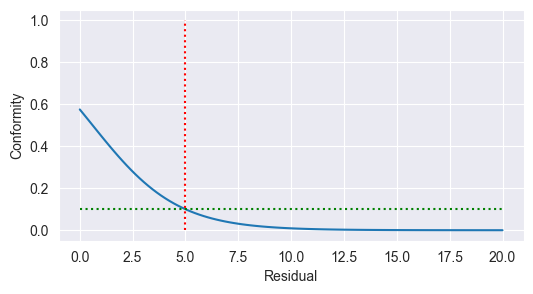

In [80]:
thresh = 5
k = 0.5
thresh_conformity = 0.1

x = np.linspace(0, 20, 100)
y = linear_conformity(x, thresh, thresh_conformity, k)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y)
ax.vlines(thresh, 0, 1, color="red", linestyle=":")
ax.hlines(thresh_conformity, 0, 20, color="green", linestyle=":")
ax.set_xlabel("Residual")
ax.set_ylabel("Conformity")

# Model Testing

In [9]:
# Calculate IDR of calories
cal_idr = cereals_df.select(pl.col("calories")).quantile(0.90) - cereals_df.select(pl.col("calories")).quantile(0.10)
cal_idr

calories
f64
40.0


In [10]:
cereals_df.select(pl.col("calories")).quantile(0.25)

calories
f64
100.0


In [11]:
cal_iqr = pl.col("calories").quantile(0.75) - pl.col("calories").quantile(0.25)
cal_idr = pl.col("calories").quantile(0.9) - pl.col("calories").quantile(0.1)
cal_mad = (pl.col("calories") - pl.col("calories").median()).abs().median()

In [59]:
results_df = (cereals_df.select(
    pl.col("carbs", "protein", "fat"),
    expected=pl.col("calories"),
    predicted=fit.predict().alias("calories_pred"),
    err=fit.errors().abs().alias("err"),
    # MAD of calories
    threshold=cal_idr
).with_columns(
    is_outlier=pl.col("err") > pl.col("threshold")
)
.with_columns(
    macro_sum=pl.concat_list("carbs", "protein", "fat").apply(
        methodcaller("dot", CALORIES_PER.values())
    )
))
results_df;

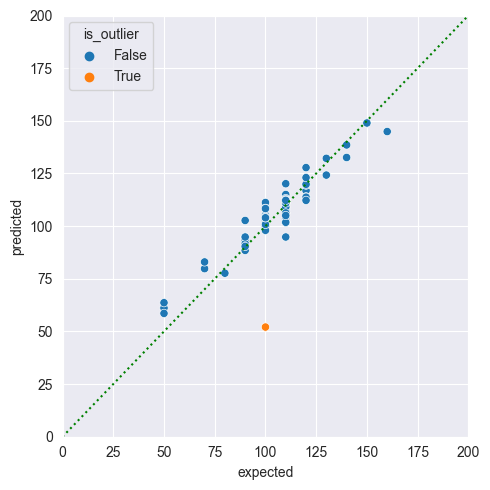

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
# todo: plot the trend line properly! 
ax.plot([0, 200], [0, 200], color="green", linestyle=":")
sns.scatterplot(ax=ax, data=results_df, x="expected", y="predicted", hue="is_outlier")
fig.tight_layout()

In [14]:
results_df.with_row_count().filter(pl.col("is_outlier")).sort("err", descending=True)

row_nr,carbs,protein,fat,expected,predicted,err,threshold,is_outlier,macro_sum
u32,f64,i64,i64,i64,f64,f64,f64,bool,f64
57,-2.0,5,2,100,52.0661,47.9339,40.0,true,30.0


# RANSAC (Reference)

In [15]:
from sklearn.linear_model import RANSACRegressor

In [30]:
ransac = RANSACRegressor(random_state=42)
ransac.fit(cereals_df.select(pl.col("carbs", "protein", "fat")), cereals_df.select(pl.col("calories")))
ransac.estimator_.coef_

array([[4.27083113, 3.83197661, 8.76023291]])

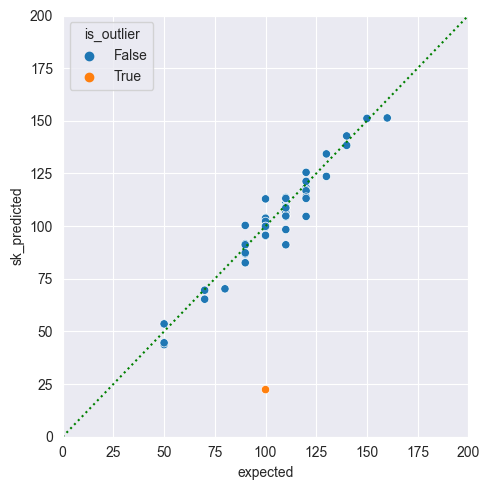

In [53]:
fig, axs = plt.subplots(2, figsize=(5, 5))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.plot([0, 200], [0, 200], color="green", linestyle=":")
sns.scatterplot(ax=ax, data=results_df.with_columns(
    sk_predicted=pl.lit(ransac.predict(cereals_df.select(pl.col("carbs", "protein", "fat"))).reshape(-1))
), x="expected", y="sk_predicted", hue="is_outlier")
fig.tight_layout()